In [4]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define paths (adjust as needed)
subject = "sub-001"
ses = "ses-01"
run = "run-03"
base_path = "/Users/jananjahed/Desktop/Bachelor's project/ds005873"
edf_path = f"{base_path}/{subject}/{ses}/eeg/{subject}_{ses}_task-szMonitoring_{run}_eeg.edf"
events_tsv_path = f"{base_path}/{subject}/{ses}/eeg/{subject}_{ses}_task-szMonitoring_{run}_events.tsv"

# Load EDF file
raw = mne.io.read_raw_edf(edf_path, preload=True)
events_df = pd.read_csv(events_tsv_path, sep="\t")

# Print data info
print("="*50)
print("RAW DATA INFO:")
print(raw.info)
print("\nEVENTS:")
print(events_df.head())

Extracting EDF parameters from /Users/jananjahed/Desktop/Bachelor's project/ds005873/sub-001/ses-01/eeg/sub-001_ses-01_task-szMonitoring_run-03_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 16634623  =      0.000 ... 64978.996 secs...
RAW DATA INFO:
<Info | 8 non-empty values
 bads: []
 ch_names: BTEleft SD, CROSStop SD
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 2
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: x, sex: 2, last_name: x>
>

EVENTS:
     onset  duration     eventType lateralization localization vigilance  \
0  23059.0       6.0          impd            NaN          NaN       NaN   
1  23248.0       5.0          impd            NaN          NaN       NaN   
2  57975.0      72.0  sz_foc_ia_nm           left         temp    asleep   

   confidence  channels             dateTime  recordingDuration  
0         NaN       

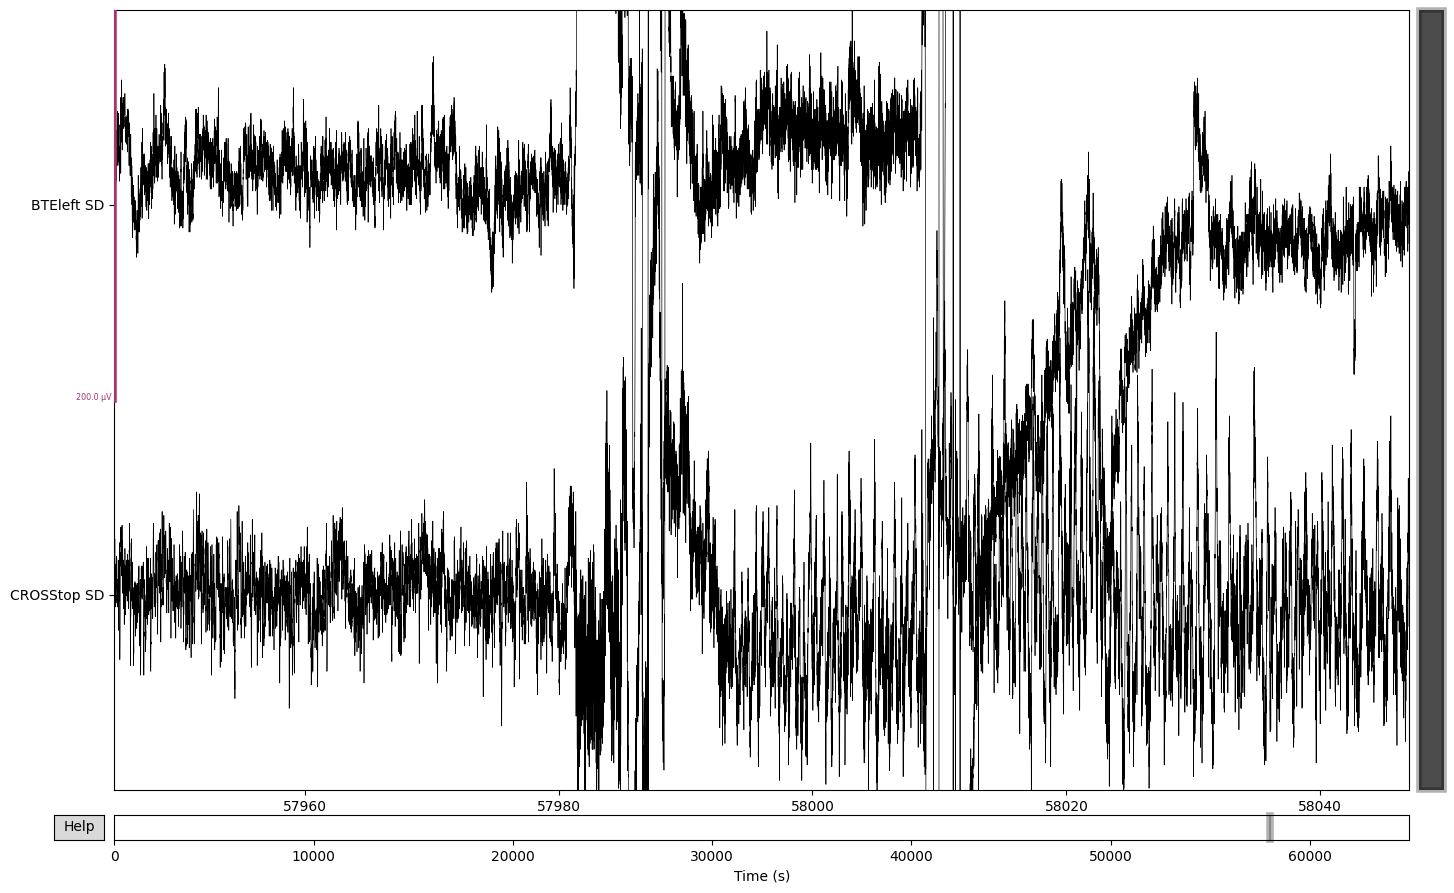

In [8]:
# Define seizure onset and duration
seizure_onset = 57975  # seconds
seizure_duration = 72  # seconds

# Add 10 seconds pre-onset
pre_onset_buffer = 30
start_time = seizure_onset - pre_onset_buffer
total_duration = seizure_duration + pre_onset_buffer

# Plot EEG with pre-onset context
raw.plot(start=start_time, duration=total_duration, 
         scalings=dict(eeg=1e-4), title="Seizure with 10s Pre-Onset")
plt.show()



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=False).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


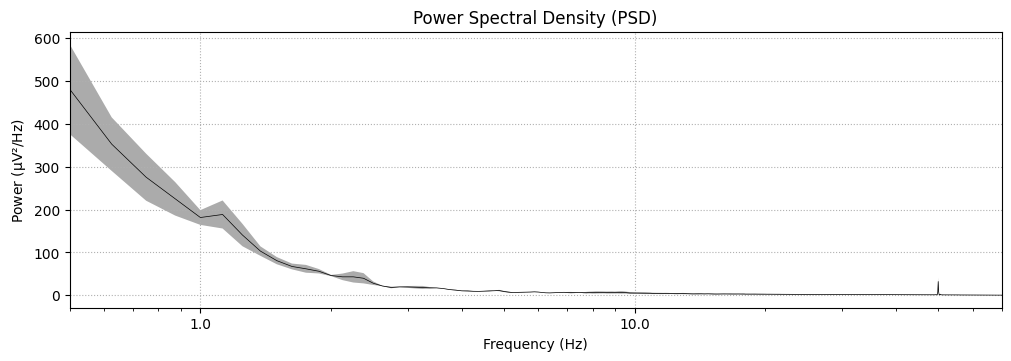

In [9]:
# Compute PSD
raw.plot_psd(fmin=0.5, fmax=70, dB=False, xscale='log', average=True)
plt.title("Power Spectral Density (PSD)")
plt.show()

Constructed events array:
[[14841600        0        1]]
Not setting metadata
1 matching events found
Setting baseline interval to [-10.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 10241 original time points ...
0 bad epochs dropped


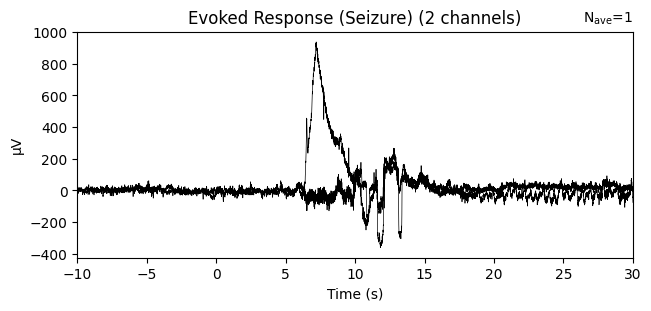

In [10]:
# Filter for seizure events (adjust the condition if needed)
seizure_events = events_df[events_df["eventType"].str.startswith("sz_")]

# Debug: Check if seizure_events is empty
if seizure_events.empty:
    print("No seizure events found in the current TSV file.")
else:
    # Compute sample indices for seizure onsets
    sfreq = raw.info["sfreq"]
    onset_samples = (seizure_events["onset"] * sfreq).astype(int)
    
    # Construct events array with 3 columns: [sample, 0, event_id]
    events_array = np.column_stack((onset_samples, np.zeros(len(onset_samples), dtype=int), np.ones(len(onset_samples), dtype=int)))
    print("Constructed events array:")
    print(events_array)
    
    # Create epochs with tmin=-10 (pre-event) and tmax=30 (post-event)
    epochs_seizure = mne.Epochs(raw, 
                                events=events_array, 
                                event_id={'seizure': 1},
                                tmin=-10, tmax=30,
                                baseline=(None, 0),
                                preload=True)
    
    # Plot the averaged evoked response
    evoked_seizure = epochs_seizure.average()
    evoked_seizure.plot(titles="Evoked Response (Seizure)")
    plt.show()

In [32]:
import glob
import os
import pandas as pd
import numpy as np

# Base path where your project is located
base_path = "/Users/jananjahed/Desktop/Bachelor's project/ds005873"

# Recursively find all TSV files that end with _events.tsv
tsv_files = glob.glob(os.path.join(base_path, "**", "*_events.tsv"), recursive=True)
print(f"Found {len(tsv_files)} TSV files.")

all_durations = []

for tsv_file in tsv_files:
    df = pd.read_csv(tsv_file, sep="\t")
    # Filter for seizure events (assuming eventType starts with "sz")
    seizure_df = df[df["eventType"].str.startswith("sz")]
    if not seizure_df.empty:
        durations = seizure_df["duration"].values
        all_durations.extend(durations)

if all_durations:
    all_durations = np.array(all_durations)
    median_duration = np.median(all_durations)
    average_duration = np.mean(all_durations)
    print(f"Median seizure duration: {median_duration:.2f} seconds")
    print(f"Average seizure duration: {average_duration:.2f} seconds")
else:
    print("No seizure events found in the TSV files.")


Found 2853 TSV files.
Median seizure duration: 33.00 seconds
Average seizure duration: 58.37 seconds


In [33]:
total_seizure_events = 0
total_non_seizure_events = 0

for tsv_file in tsv_files:
    df = pd.read_csv(tsv_file, sep="\t")
    # Count seizure events: those with eventType starting with "sz"
    seizure_events = df[df["eventType"].str.startswith("sz")]
    total_seizure_events += seizure_events.shape[0]
    
    # Count non-seizure events: those that do NOT start with "sz"
    non_seizure_events = df[~df["eventType"].str.startswith("sz")]
    total_non_seizure_events += non_seizure_events.shape[0]

print(f"Total seizure events: {total_seizure_events}")
print(f"Total non-seizure events: {total_non_seizure_events}")

Total seizure events: 886
Total non-seizure events: 2778
